# Capstone Bite 1

Use this space to write code for your first capstone bite. 

Feel free to add as many code cells as you want, using the plus button. 

You may also want to add Markdown cells to write text explaining your work. To add a markdown cell, use the plus button to create a new cell. Then, use the dropdown menu next to the run button to change the cell type from "Code" to "Markdown". If you "run" a Markdown cell, it will format the text nicely.

Finally, in this capstone bite, you will need to upload a dataset. To do this, first save, and then click on the "Jupyter" logo in the top left corner of this page. This will cause you to exit this Jupyter notebook and you will see a file system. You can then upload any files using the "Upload" button. You can also click back into this notebook to continue your coding work after uploading your files.

##### MINOR REWORK NOTES:
   - As I was continuing to do EDA I noticed that there were multiple rows that were flagged as both toxic and neutral, meaning something went wrong when I created the neutral column. I reworked my approach to create that column and now the data looks correct.  

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


##### Upfront General Notes:
- this is preliminary cleaning and inspection. 
- may include some feature engineering for eventual modeling.
- looking into the best ways to preprocess text for topic modeling using LDA  would like to use this as a part of the EDA process
- Intending to use VADER for sentiment analysis
- looking into any additional data augmentation steps for BERT
- Will also model with Multinomial Naive Bayes and a regular feed forward neural network as points of comparison
- quick look at the data shows there are large class imbalances - so I may need to use Imblearn to oversample minority class. 
- once I have these steps done locally, want to use Amazon Sagemaker for cloud computing
- Would love to build a quick web app using Streamlit to demonstrate the model's capabilities. 
- One idea for how to handle the huge class imbalances is make first model that can simply detect if the text falls into any of the toxic classes or is non-toxic. If toxic, text is fed into secondary model to determine what type of toxicity.  Use model stacking? Or just pipelines?


In [2]:
#read in data

train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

In [3]:
#function to get quick inspection of data
def quick_inspect(df):
    print(df.head())
    print('==================================================')
    print(df.info())
    print('==================================================')
    print(df.isnull().sum())

In [4]:
quick_inspect(train)

                 id                                       comment_text  toxic  \
0  0000997932d777bf  Explanation\nWhy the edits made under my usern...      0   
1  000103f0d9cfb60f  D'aww! He matches this background colour I'm s...      0   
2  000113f07ec002fd  Hey man, I'm really not trying to edit war. It...      0   
3  0001b41b1c6bb37e  "\nMore\nI can't make any real suggestions on ...      0   
4  0001d958c54c6e35  You, sir, are my hero. Any chance you remember...      0   

   severe_toxic  obscene  threat  insult  identity_hate  
0             0        0       0       0              0  
1             0        0       0       0              0  
2             0        0       0       0              0  
3             0        0       0       0              0  
4             0        0       0       0              0  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 8 columns):
id               159571 non-null object
comment_text   

In [5]:
quick_inspect(test)

                 id                                       comment_text
0  00001cee341fdb12  Yo bitch Ja Rule is more succesful then you'll...
1  0000247867823ef7  == From RfC == \n\n The title is fine as it is...
2  00013b17ad220c46  " \n\n == Sources == \n\n * Zawe Ashton on Lap...
3  00017563c3f7919a  :If you have a look back at the source, the in...
4  00017695ad8997eb          I don't anonymously edit articles at all.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 153164 entries, 0 to 153163
Data columns (total 2 columns):
id              153164 non-null object
comment_text    153164 non-null object
dtypes: object(2)
memory usage: 2.3+ MB
None
id              0
comment_text    0
dtype: int64


In [6]:
#checking class balances
def check_classes(df):
    col_list = list(df.columns)[2:]
    for col in col_list:
        print(df[col].value_counts())
        print(df[col].value_counts(normalize = True))
        print('================')

In [7]:
check_classes(train)

0    144277
1     15294
Name: toxic, dtype: int64
0    0.904156
1    0.095844
Name: toxic, dtype: float64
0    157976
1      1595
Name: severe_toxic, dtype: int64
0    0.990004
1    0.009996
Name: severe_toxic, dtype: float64
0    151122
1      8449
Name: obscene, dtype: int64
0    0.947052
1    0.052948
Name: obscene, dtype: float64
0    159093
1       478
Name: threat, dtype: int64
0    0.997004
1    0.002996
Name: threat, dtype: float64
0    151694
1      7877
Name: insult, dtype: int64
0    0.950636
1    0.049364
Name: insult, dtype: float64
0    158166
1      1405
Name: identity_hate, dtype: int64
0    0.991195
1    0.008805
Name: identity_hate, dtype: float64


What percentage of comments are considered toxic (any type)?

In [8]:
train.shape

(159571, 8)

In [9]:
train['toxic'].value_counts()

0    144277
1     15294
Name: toxic, dtype: int64

In [10]:
def sum_tox(df):
    tox_list = []
    col_list = list(df.columns)[2:]
    for col in col_list:
        tox_list.append(df[col].value_counts()[1])
        
    print(tox_list)
    print(sum(tox_list))
    print((sum(tox_list)/df.shape[0]))

In [11]:
sum_tox(train)

[15294, 1595, 8449, 478, 7877, 1405]
35098
0.2199522469621673


#### later found that this is not accurate since these are multilabel, not just multiclass, but keeping it here becuase i want to come back to this

In [12]:
sum([1595, 8449, 478, 7877, 1405])

19804

Only about 22% of the dataset is considered toxic in some capacity... 
#we've got extremely imbalanced classes, especially when you spread it out between 6 different toxicity classes. (22% is the sum of all 6 toxicity classes)

- going to try a couple of things to get around this...
- first model to simply determine if the comment is toxic (any) or neutral.
- second model - if found to be toxic, secondary model will determine with type. 
- Still have imbalanced classes amongst the toxicity types, but can try to use Imblearn if that is an issue.

In [13]:
train.columns

Index(['id', 'comment_text', 'toxic', 'severe_toxic', 'obscene', 'threat',
       'insult', 'identity_hate'],
      dtype='object')

wait... unclear from kaggle description if a comment can have different toxicity classes...


In [14]:

train[train['identity_hate'] == 1][:5]

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
42,001810bf8c45bf5f,You are gay or antisemmitian? \n\nArchangel WH...,1,0,1,0,1,1
105,00472b8e2d38d1ea,A pair of jew-hating weiner nazi schmucks.,1,0,1,0,1,1
176,006b94add72ed61c,I think that your a Fagget get a oife and burn...,1,0,1,1,1,1
218,008e0818dde894fb,"Kill all niggers. \n\nI have hard, that others...",1,0,1,0,1,1
238,0097dd5c29bf7a15,u r a tw@ fuck off u gay boy.U r smelly.Fuck u...,1,0,1,0,1,1


notes: ok, so a comment can be labeled as having multiple types of toxicity.
to get more than one prediction for each observation I'll need to use a multi-label classification model.
i think what i may need to do to get more than just one prediction (so I can predict multiple types per observation), is use a multilabel classification model - Can do this with CNNs, RNNs and BERT and RoBERTa.
I Maaaayyy try to all of the above? I'd like to play more with RNNs since I know they're also really commonly used with timeseries data and my team works alot with timeseries, so that would be a good transferrable skill. 

What about toxic vs severe toxic? Can an observation be both?

In [15]:
tox = train[['toxic', 'severe_toxic']]

def all_ones(df):
    all_ones_mask =(df == 1).all(axis = 1)
    all_ones_rows = df[all_ones_mask]
    
    return all_ones_rows

all_ones(tox)[:5]

,toxic,severe_toxic
6,1,1
55,1,1
181,1,1
442,1,1
579,1,1


- Alright, so the quick answer is that rows can be both toxic and severely toxic
- curious to see how many different combinations we have of the varying types of toxicity..

- going to move on to some text cleaning before figuring that out. 

In [16]:
labels_only = train[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']]

In [17]:
#For now I'll add a neutral column to account for the comments that are not toxic, will parse out dataset later

def add_neutral_column(df):
    # Create a new column 'neutral' initialized with 0s
    df['neutral'] = 0

    # Check if any row contains a 1 in other columns, if not, set 'neutral' to 1
    df['neutral'] = df.apply(lambda row: 1 if row.sum() == 0 else 0, axis=1)

    return df

In [18]:
labels= add_neutral_column(labels_only)

/Users/heatherrobbins/env3/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/Users/heatherrobbins/env3/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [19]:
labels.head()

,toxic,severe_toxic,obscene,threat,insult,identity_hate,neutral
0,0,0,0,0,0,0,1
1,0,0,0,0,0,0,1
2,0,0,0,0,0,0,1
3,0,0,0,0,0,0,1
4,0,0,0,0,0,0,1


need to concat other columns back on to this now - really only need the comment column

In [20]:
train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [21]:
# Concat labels df back with comment text
tox = pd.concat([labels, train['comment_text']], axis=1)


In [22]:
tox.head()

,toxic,severe_toxic,obscene,threat,insult,identity_hate,neutral,comment_text
0,0,0,0,0,0,0,1,Explanation\nWhy the edits made under my usern...
1,0,0,0,0,0,0,1,D'aww! He matches this background colour I'm s...
2,0,0,0,0,0,0,1,"Hey man, I'm really not trying to edit war. It..."
3,0,0,0,0,0,0,1,"""\nMore\nI can't make any real suggestions on ..."
4,0,0,0,0,0,0,1,"You, sir, are my hero. Any chance you remember..."


In [23]:
tox.shape

(159571, 8)

In [24]:
tox.isnull().sum()

toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
neutral          0
comment_text     0
dtype: int64

In [25]:
#checking value counts of label columns again since I added a new one

labels = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate', 'neutral']

for label in labels:
    print(tox[label].value_counts(normalize = True))

0    0.904156
1    0.095844
Name: toxic, dtype: float64
0    0.990004
1    0.009996
Name: severe_toxic, dtype: float64
0    0.947052
1    0.052948
Name: obscene, dtype: float64
0    0.997004
1    0.002996
Name: threat, dtype: float64
0    0.950636
1    0.049364
Name: insult, dtype: float64
0    0.991195
1    0.008805
Name: identity_hate, dtype: float64
1    0.898321
0    0.101679
Name: neutral, dtype: float64


Now that I fixed the Neutral column, these are more imbalanced than previously thought. 

Let's clean up some of the text to take a quick look at sentiment...

In [26]:
#function to clean text (line breaks, html, email addresses, website links)

import re

In [27]:
def clean_text(text):
    
    #replace line breaks with empty space
    cleaner_text = text.replace('\n', ' ').replace('\r', ' ')
    
    ##remove website links
    cleaner_text = re.sub(r'http[s]?://\S+', '', cleaner_text)
    
    #remove email addresses
    
    cleaner_text = re.sub(r'\S+@\S+', '', cleaner_text)
    
    #remove html tags
    cleaner_text = re.sub(r'<[^>]+>', '', cleaner_text)
    
    #remove urls
    cleaner_text = re.sub(r'www\.\S+', '', cleaner_text)
    
    return cleaner_text

#had help with some of the regex from regex cheat sheet and a bit from chatgpt to help with formatting
# https://www.rexegg.com/regex-quickstart.html
# https://stackoverflow.com/questions/11331982/how-to-remove-any-url-within-a-string-in-python


In [28]:
tox['cleaner_text'] = tox['comment_text'].map(lambda text: clean_text(text))

In [29]:
tox.head()

,toxic,severe_toxic,obscene,threat,insult,identity_hate,neutral,comment_text,cleaner_text
0,0,0,0,0,0,0,1,Explanation\nWhy the edits made under my usern...,Explanation Why the edits made under my userna...
1,0,0,0,0,0,0,1,D'aww! He matches this background colour I'm s...,D'aww! He matches this background colour I'm s...
2,0,0,0,0,0,0,1,"Hey man, I'm really not trying to edit war. It...","Hey man, I'm really not trying to edit war. It..."
3,0,0,0,0,0,0,1,"""\nMore\nI can't make any real suggestions on ...",""" More I can't make any real suggestions on im..."
4,0,0,0,0,0,0,1,"You, sir, are my hero. Any chance you remember...","You, sir, are my hero. Any chance you remember..."


In [30]:
tox.isnull().sum()

toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
neutral          0
comment_text     0
cleaner_text     0
dtype: int64

I may come back and do more cleaning of special characters, but for now I want to leave things like punctuation and capitalization since it may be indicative of toxic language. This will be used in a feature engineering notebook later, most likely.

##### Sentiment Analysis with VADER

let's add a sentiment column.. not sure how fruitful this will be, but want to see. I'm going to use VADER since it was designed to work well with social media text where there may be slang, emojis, abbreviations, etc.

In [31]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

In [32]:
## need to convert text to a list of strings

corpus = list(tox['cleaner_text'])
corpus[:5]

["Explanation Why the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27",
 "D'aww! He matches this background colour I'm seemingly stuck with. Thanks.  (talk) 21:51, January 11, 2016 (UTC)",
 "Hey man, I'm really not trying to edit war. It's just that this guy is constantly removing relevant information and talking to me through edits instead of my talk page. He seems to care more about the formatting than the actual info.",
 '" More I can\'t make any real suggestions on improvement - I wondered if the section statistics should be later on, or a subsection of ""types of accidents""  -I think the references may need tidying so that they are all in the exact same format ie date format etc. I can do that later on, if no-one else does first - if you have any preferences for formatting style on refe

In [33]:
#instaniate sia
sia = SentimentIntensityAnalyzer()

#quick check to make sure it's working as expected

sia.polarity_scores(corpus[0])

{'neg': 0.0, 'neu': 0.897, 'pos': 0.103, 'compound': 0.5574}

--- notes from the white paper and documentation:

- The 'compound' score is compute dby summing the scores of each word. Then it is normalized between -1 (most extreme neative) and +1 (most extreme positive).
- This is the best unidimensional metric of sentiment
- Can also be called a normalized, weighted, composite score.


- positive sentiment: a compound score greater than 0.05
- neutral sentiment: a compound score of between 0.05 and -0.05
- negative sentiment: compound score less than 0.05

In [34]:
# create a df that contains the different polarity score

sentiment = []

for comment in corpus:
    scores = sia.polarity_scores(comment)
    scores['cleaner_text'] = comment
    sentiment.append(scores)
    
sentiment_df = pd.DataFrame(sentiment)

sentiment_df.head()

,cleaner_text,compound,neg,neu,pos
0,Explanation Why the edits made under my userna...,0.5574,0.000,0.897,0.103
1,D'aww! He matches this background colour I'm s...,0.2942,0.099,0.743,0.158
2,"Hey man, I'm really not trying to edit war. It...",-0.1779,0.083,0.849,0.068
3,""" More I can't make any real suggestions on im...",0.5106,0.022,0.916,0.062
4,"You, sir, are my hero. Any chance you remember...",0.6808,0.000,0.663,0.337


In [35]:
sentiment_df.tail(5)

,cleaner_text,compound,neg,neu,pos
159566,""":::::And for the second time of asking, when ...",-0.1414,0.110,0.791,0.099
159567,You should be ashamed of yourself That is a ...,-0.7650,0.306,0.694,0.000
159568,"Spitzer Umm, theres no actual article for pr...",-0.2960,0.180,0.820,0.000
159569,And it looks like it was actually you who put ...,0.3612,0.000,0.902,0.098
159570,""" And ... I really don't think you understand....",-0.7003,0.183,0.759,0.058


In [36]:
tox.tail()

,toxic,severe_toxic,obscene,threat,insult,identity_hate,neutral,comment_text,cleaner_text
159566,0,0,0,0,0,0,1,""":::::And for the second time of asking, when ...",""":::::And for the second time of asking, when ..."
159567,0,0,0,0,0,0,1,You should be ashamed of yourself \n\nThat is ...,You should be ashamed of yourself That is a ...
159568,0,0,0,0,0,0,1,"Spitzer \n\nUmm, theres no actual article for ...","Spitzer Umm, theres no actual article for pr..."
159569,0,0,0,0,0,0,1,And it looks like it was actually you who put ...,And it looks like it was actually you who put ...
159570,0,0,0,0,0,0,1,"""\nAnd ... I really don't think you understand...",""" And ... I really don't think you understand...."


In [37]:
## merging the original df with the sentiment df

tox_with_sent = pd.merge(tox, sentiment_df, left_index = True, right_index = True)

In [38]:
tox_with_sent.shape

(159571, 14)

In [39]:
tox_with_sent.isnull().sum()

toxic             0
severe_toxic      0
obscene           0
threat            0
insult            0
identity_hate     0
neutral           0
comment_text      0
cleaner_text_x    0
cleaner_text_y    0
compound          0
neg               0
neu               0
pos               0
dtype: int64

In [40]:
tox_with_sent.columns

Index(['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate',
       'neutral', 'comment_text', 'cleaner_text_x', 'cleaner_text_y',
       'compound', 'neg', 'neu', 'pos'],
      dtype='object')

In [41]:
tox_with_sent.drop(columns = 'cleaner_text_y', inplace = True)
tox_with_sent.rename(columns = {'cleaner_text_x': 'cleaner_text'}, inplace = True)

In [42]:
print(tox.shape)
print(sentiment_df.shape)
print(tox_with_sent.shape)

(159571, 9)
(159571, 5)
(159571, 13)


In [43]:
tox_with_sent.isnull().sum()

toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
neutral          0
comment_text     0
cleaner_text     0
compound         0
neg              0
neu              0
pos              0
dtype: int64

take a look at the sentiment score for different classes of toxicity - this will be imperfect since there's overlap between types, but worth looking at

In [44]:
toxic = tox_with_sent[tox_with_sent['toxic'] == 1]
neutral = tox_with_sent[tox_with_sent['neutral'] == 1]

In [45]:
toxic.head(2)

,toxic,severe_toxic,obscene,threat,insult,identity_hate,neutral,comment_text,cleaner_text,compound,neg,neu,pos
6,1,1,1,0,1,0,0,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,-0.7783,0.531,0.469,0.000
12,1,0,0,0,0,0,0,Hey... what is it..\n@ | talk .\nWhat is it......,Hey... what is it.. @ | talk . What is it... a...,0.3034,0.130,0.673,0.197


In [46]:
neutral.head(2)

,toxic,severe_toxic,obscene,threat,insult,identity_hate,neutral,comment_text,cleaner_text,compound,neg,neu,pos
0,0,0,0,0,0,0,1,Explanation\nWhy the edits made under my usern...,Explanation Why the edits made under my userna...,0.5574,0.000,0.897,0.103
1,0,0,0,0,0,0,1,D'aww! He matches this background colour I'm s...,D'aww! He matches this background colour I'm s...,0.2942,0.099,0.743,0.158


In [47]:
#I'll focus on compound score

In [48]:
toxic.sort_values(by = 'compound', ascending = False).head(10)

,toxic,severe_toxic,obscene,threat,insult,identity_hate,neutral,comment_text,cleaner_text,compound,neg,neu,pos
101774,1,0,0,0,0,0,0,SUPER GAY SUPER GAY SUPER GAY SUPER GAY SUPER ...,SUPER GAY SUPER GAY SUPER GAY SUPER GAY SUPER ...,1.0000,0.000,0.204,0.796
121514,1,0,0,0,0,0,0,"I hate you \n\n== \n\nBrothers and sisters, I...","I hate you == Brothers and sisters, In th...",1.0000,0.100,0.388,0.511
153907,1,0,1,0,1,0,0,btw mark arsten is a son of a bitch his cock i...,btw mark arsten is a son of a bitch his cock i...,1.0000,0.005,0.421,0.574
31454,1,0,0,0,0,0,0,LMAO so you reported me ahahahahahahahahahahah...,LMAO so you reported me ahahahahahahahahahahah...,0.9999,0.000,0.517,0.483
37497,1,1,1,0,0,0,0,wikipedia loves cock \n\nwikipedia loves cock ...,wikipedia loves cock wikipedia loves cock wi...,0.9999,0.254,0.159,0.587
72192,1,0,0,0,0,0,0,China smells like fart. China smells like fart...,China smells like fart. China smells like fart...,0.9999,0.000,0.446,0.554
94557,1,0,0,0,0,0,0,"Gamaliel enjoys making love to animals, and Bi...","Gamaliel enjoys making love to animals, and Bi...",0.9998,0.000,0.665,0.335
131729,1,1,1,0,1,0,0,"""FFFFF UUUUUU CCCCCC KKKKKK ===== YOU! F UU C ...","""FFFFF UUUUUU CCCCCC KKKKKK ===== YOU! F UU C ...",0.9998,0.000,0.712,0.288
2366,1,0,1,0,1,1,0,User:NHRHS2010 is a homo like mitt romney is. ...,User:NHRHS2010 is a homo like mitt romney is. ...,0.9996,0.000,0.714,0.286
22852,1,1,0,0,0,0,0,User:NHRHS2010 is a homo like mitt romney is. ...,User:NHRHS2010 is a homo like mitt romney is. ...,0.9995,0.000,0.705,0.295


In [49]:
neutral.sort_values(by = 'compound', ascending = False).head(10)

,toxic,severe_toxic,obscene,threat,insult,identity_hate,neutral,comment_text,cleaner_text,compound,neg,neu,pos
110132,0,0,0,0,0,0,1,these two users are correct. chliorine is a go...,these two users are correct. chliorine is a go...,1.0000,0.059,0.485,0.455
66815,0,0,0,0,0,0,1,THE BEST THE BEST THE BEST THE BEST THE BEST T...,THE BEST THE BEST THE BEST THE BEST THE BEST T...,1.0000,0.000,0.169,0.831
69846,0,0,0,0,0,0,1,hey i like Jews hey i like Jews hey i like Jew...,hey i like Jews hey i like Jews hey i like Jew...,1.0000,0.000,0.444,0.556
18183,0,0,0,0,0,0,1,Hey guys I love chicken rice=)Hey guys I love ...,Hey guys I love chicken rice=)Hey guys I love ...,1.0000,0.000,0.415,0.585
138069,0,0,0,0,0,0,1,were THE BEST THE BEST THE BEST THE BEST THE B...,were THE BEST THE BEST THE BEST THE BEST THE B...,1.0000,0.000,0.169,0.831
150039,0,0,0,0,0,0,1,LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LO...,LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LO...,1.0000,0.000,0.000,1.000
9365,0,0,0,0,0,0,1,"Heaven of God \n\nTo understand Heaven, then G...","Heaven of God To understand Heaven, then God...",0.9999,0.028,0.601,0.370
28688,0,0,0,0,0,0,1,"Heaven of God \nFor the atheist anarchist, the...","Heaven of God For the atheist anarchist, the ...",0.9999,0.028,0.607,0.365
11630,0,0,0,0,0,0,1,you are cool\nyou are cool\nyou are cool\nyou ...,you are cool you are cool you are cool you are...,0.9998,0.000,0.465,0.535
97016,0,0,0,0,0,0,1,"""Happy Town is a little town based in Newtowna...","""Happy Town is a little town based in Newtowna...",0.9998,0.082,0.606,0.312


In [50]:
#### If presenting any of this sentiment stuff, good place to take a moment to talk about the imperfections of sentiment analysis

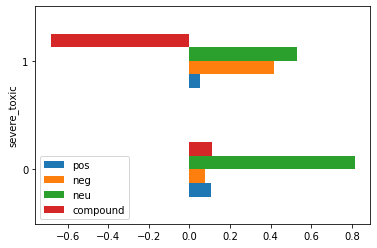

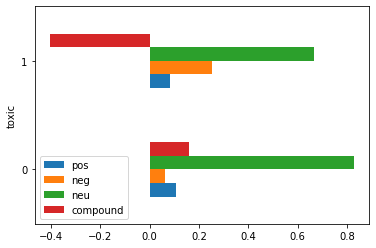

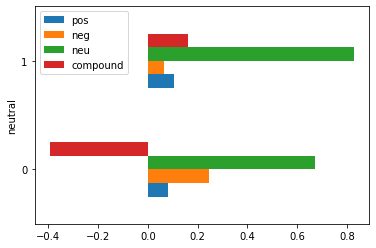

In [51]:
#quick plots

tox_with_sent.groupby('severe_toxic').mean()[['pos', 'neg', 'neu', 'compound']].plot(kind = 'barh')
tox_with_sent.groupby('toxic').mean()[['pos', 'neg', 'neu', 'compound']].plot(kind = 'barh')
tox_with_sent.groupby('neutral').mean()[['pos', 'neg', 'neu', 'compound']].plot(kind = 'barh')

In [52]:
## aiming to work more on this over the weekend to figure out how to use LDA for topic modeling. Still thinking about how I want to handle the class imbalances and the multilabel targets.
#I'm curious to see if there are any specific topic areas that are discussed amongst the neutral and toxic comments, or if there are any topics that lend themselves to more toxic commentary. 

#planning to also do more EDA on different types of special characters in the text - low hanging fruit would be things like exclamation marks, app caps, things that could indicate yelling/aggression
#

In [55]:
tox_with_sent.isnull().sum()

toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
neutral          0
comment_text     0
cleaner_text     0
compound         0
neg              0
neu              0
pos              0
dtype: int64

In [56]:
tox_with_sent.to_csv('tox_with_sent_no_nulls.csv', index = False)